In [1]:
import matplotlib.pyplot as plt

import numpy as np 
from numpy import sin, cos


from pydrake.common.value import Value
from pydrake.systems.framework import DiagramBuilder, LeafSystem, BasicVector
from pydrake.systems.primitives import LogVectorOutput
from pydrake.systems.framework import Context, ContinuousState, SystemOutput
from pydrake.systems.controllers import PidController
from pydrake.all import Simulator, ConstantVectorSource



In [14]:


class PlanarPRR_continuous(LeafSystem):

    def __init__(self):

        LeafSystem.__init__(self)

        self.M = np.zeros((3, 3))
        self.C = np.zeros((3))
        self.ActuationMatrix = np.zeros((3, 2))
        self.Jac = np.zeros((3, 3))

        # def joint limit: 
        self.limit_q1 = 12
        self.limit_q2 = np.pi
        self.limit_q3 = np.pi

        group_index = self.DeclareContinuousState(6)

        self.DeclareVectorInputPort("F", BasicVector(2))
        self.DeclareStateOutputPort("q_state", group_index)
        
        self.init_dynamic_model_parameters()

    def DoCalcTimeDerivatives(self, context:Context, derivatives_out:ContinuousState):

        fx, fy = self.get_input_port(0).Eval(context)
        F = np.array([fx, fy])
        state = context.get_continuous_state_vector()

        # test on fixing joint limit. Still to do: this next lines doesn't work
        #dq1 = min(max(state[3], -self.limit_q1), self.limit_q1)
        #dq2 = min(max(state[4], -self.limit_q2), self.limit_q2)
        #dq3 = min(max(state[5], -self.limit_q3), self.limit_q3)

        dq1, dq2, dq3 = state[3], state[4], state[5]
        self.eval_dyn_model(state_vect=state)
        q_dot = np.array([dq1, dq2, dq3])
        q_dot_dot = np.linalg.inv(self.M) @ ((self.ActuationMatrix @ F) - self.C)
        derivatives = np.concatenate( (q_dot, q_dot_dot) )
        derivatives_out.get_mutable_vector().SetFromVector(derivatives)

    def init_dynamic_model_parameters(self):

        self.m = [1, 1, 1]
        self.I = [1, 1, 1]
        self.d = [None, 0.5, 0.5]
        self.l = [None, 1, 1]  # the first is none because is q1
        
        self.a1 = self.m[0] + self.m[1] + self.m[2]
        self.a2 = self.I[1] + self.m[1] * (self.d[1]**2) + self.m[2]*(self.l[2]**2)
        self.a3 = self.I[2] + self.m[2] * (self.d[2]**2)
        self.a4 = self.m[2] * self.d[2]
        self.a5 = self.m[1] * self.d[1] + self.m[2] * self.l[1]

    def eval_dyn_model(self, state_vect):
        self._eval_M_of_q(state_vect)
        self._eval_C_of_q(state_vect)
        self._eval_actuation_matrix(state_vect)

    def _eval_M_of_q(self, state_vect):

        q1, q2, q3 = state_vect[0], state_vect[1], state_vect[2]
        
        self.M[0, 0] =  self.a1
        self.M[0, 1] = -self.a5 * sin(q2)  - self.a4 * sin(q2 + q3)
        self.M[0, 2] = -self.a4 * sin(q2 + q3)

        self.M[1, 0] = -self.a5 * sin(q2) - self.a4 * sin(q2 + q3)
        self.M[1, 1] = self.a2 + self.a3 + 2*self.a4 * self.l[1] * cos(q3)
        self.M[1, 2] = self.a3 + self.a4 * self.l[1] * cos(q3)

        self.M[2, 0] = -self.a4 * sin(q2 + q3)
        self.M[2, 1] = self.a3 + self.a4 * self.l[1] * cos(q3)
        self.M[2, 2] = self.a3

    def _eval_C_of_q(self, state_vec):
    
        q1, q2, q3 = state_vec[0], state_vec[1], state_vec[2]
        dq1, dq2, dq3 = state_vec[3], state_vec[4], state_vec[5]

        self.C[0] = (-self.a5*cos(q2) + self.a4*cos(q2+q3))*(dq2**2) - self.a4*cos(q2+q3)*dq3*(dq2 + dq3)
        self.C[1] = -self.a4 * self.l[1] * sin(q3) * dq3 * (2*dq2 + dq3)
        self.C[2] = self.a4 * self.l[2] * sin(q3) * (dq2**2)

    def _eval_actuation_matrix(self, state_vect):

        q1, q2, q3 = state_vect[0], state_vect[1], state_vect[2]

        self.ActuationMatrix[0, 0]  = 1
        self.ActuationMatrix[0, 1]  = 0 
        
        self.ActuationMatrix[1, 0] = -self.l[1] * sin(q2) - self.l[2] * sin(q2 + q3)
        self.ActuationMatrix[1, 1] = -self.l[1] * cos(q2) - self.l[2] * cos(q2 + q3)
        
        self.ActuationMatrix[2, 0] = -self.l[1] * sin(q2) 
        self.ActuationMatrix[2, 1] = -self.l[1] * cos(q2)


class PlanarPRR_forward_kin(LeafSystem):

    def __init__(self):
        LeafSystem.__init__(self)

        self.Jac = np.zeros((3, 3))
        self.l = np.array([None, 1, 1])

        self.DeclareVectorInputPort('q_state', BasicVector(6))
        self.DeclareVectorOutputPort('EndEffector_state', BasicVector(4), self.CalcForwardAndDiffKinematic)

    def CalcForwardAndDiffKinematic(self, context, theta_state):

        q_state = self.get_input_port(0).Eval(context)
        q = np.array([q_state[0], q_state[1], q_state[2]])
        q_dot = np.array([q_state[3], q_state[4], q_state[5]])

        self.eval_jac(q)
        theta_1, theta_2 = self.forward_kin(q)
        theta_1_dot, theta_2_dot, _ = self.Jac @ q_dot
        theta_state.SetFromVector([theta_1, theta_2, theta_1_dot, theta_2_dot])
        print(f"x_ee: {theta_1}, y_ee: {theta_2}")


    def eval_jac(self, q): 
        
        q1, q2, q3 = q[0], q[1], q[2]

        self.Jac[0] = [1, -self.l[1]*sin(q2) - self.l[2]*sin(q2+q3), - self.l[2]*sin(q2+q3)]
        self.Jac[1] = [0, self.l[1]*cos(q2) + self.l[2]*cos(q2+q3), self.l[2]*cos(q2+q3)]
        self.Jac[2] = [0, 1, 1]
    
    def forward_kin(self, q):
        q1, q2, q3 = q[0], q[1], q[2]

        theta_1 = q1 + self.l[1]*cos(q2) + self.l[2]*cos(q2+q3)
        theta_2 = self.l[1]*sin(q2) + self.l[2]*sin(q2+q3)

        return theta_1, theta_2




PlanarPRR_continuous()
PlanarPRR_forward_kin()

In [3]:
class CartesianController(LeafSystem):

    def __init__(self, kx=1.5, ky=1.5, kx_dot=10, ky_dot=10):
        
        LeafSystem.__init__(self)
        self.DeclareNumericParameter(BasicVector([kx, ky, kx_dot, ky_dot]))
        
        self.DeclareVectorInputPort('actual_state', BasicVector(4))
        self.DeclareVectorInputPort('desired_state', BasicVector(4))

        self.DeclareVectorOutputPort('F', BasicVector(2), self.CalcCartesiaForce)

    def CalcCartesiaForce(self, context, F): 
        actual_state = self.get_input_port_actual_state().Eval(context)
        desider_state = self.get_input_port_desired_state().Eval(context)

        K_vect = context.get_numeric_parameter(0).get_value()
        error = desider_state - actual_state
        
        fx = K_vect[0]*error[0] + K_vect[2]*error[2]
        fy = K_vect[1]*error[1] + K_vect[3]*error[3]

        F.SetFromVector(np.array([fx, fy]))

    def get_input_port_actual_state(self):
        return self.get_input_port(0)
    
    def get_input_port_desired_state(self):
        return self.get_input_port(1)
    
    

In [42]:
def plot_log(log_j, log_e, log_c):

    plt.figure()
    times = log_j.sample_times()

    q1, q2, q3, dq1, dq2, dq3= log_j.data()
    x_ee, y_ee, x_dot_ee, y_dot_ee = log_e.data()
    fx, fy = log_c.data()

    fig, axis = plt.subplots(3, 2)

    axis[0, 0].plot(times, q1, color='red', label='q1')
    axis[0, 0].plot(times, q2, color='green', label='q2')
    axis[0, 0].plot(times, q3, color='blue', label='q3')
    axis[0, 0].set_title('joint variable')
    axis[0, 0].legend()

    axis[0, 1].plot(times, dq1, color='red', label='dq1')
    axis[0, 1].plot(times, dq2, color='green', label='dq2')
    axis[0, 1].plot(times, dq3, color='blue', label='dq3')
    axis[0, 1].set_title("joint velocity")
    axis[0, 1].legend()

    axis[1, 0].plot(times, x_ee, color='red', label='x')
    axis[1, 0].plot(times, y_ee, color='green', label='y')
    axis[1, 0].set_title('EE position') 
    axis[1, 0].legend()


    axis[1, 1].plot(times, x_dot_ee, color='red', label='x_dot')
    axis[1, 1].plot(times, y_dot_ee, color='blue', label='y_dot')
    axis[1, 1].set_title('EE velocity')
    axis[1, 1].legend()

    axis[2, 0].plot(times, fx, label="fx")
    axis[2, 0].plot(times, fy, label='fy')
    axis[2, 0].set_title("controller output")
    axis[2, 0].legend()
    
    plt.tight_layout()
    plt.show()


x_ee: 2.0, y_ee: 0.0
x_ee: 2.0, y_ee: 0.0
x_ee: 2.0, y_ee: 0.0
x_ee: 2.0000000266666667, y_ee: -9.756097560975612e-11
x_ee: 2.000000013332815, y_ee: -4.878447352766212e-11
x_ee: 2.000000013332815, y_ee: -4.878447352766212e-11
x_ee: 2.0000000799955924, y_ee: -2.9271680688322285e-10
x_ee: 2.0000008132472606, y_ee: -2.9762714312106347e-09
x_ee: 2.000000479888003, y_ee: -1.7569585716076052e-09
x_ee: 2.000000479888003, y_ee: -1.7569585716076052e-09
x_ee: 2.0000024791880566, y_ee: -9.079413991843835e-09
x_ee: 2.000021133489442, y_ee: -7.746719603217969e-08
x_ee: 2.0000127978887763, y_ee: -4.6996862628497087e-08
x_ee: 2.0000127978887763, y_ee: -4.6996862628497087e-08
x_ee: 2.0000643711616615, y_ee: -2.3674048325811047e-07
x_ee: 2.0005311050460546, y_ee: -1.9624833557845204e-06
x_ee: 2.0003225132060836, y_ee: -1.2023028468161364e-06
x_ee: 2.0003225132060836, y_ee: -1.2023028468161364e-06
x_ee: 2.001394674305634, y_ee: -5.2370429263553685e-06
x_ee: 2.0095517346700027, y_ee: -3.669201956868718e-

<Figure size 640x480 with 0 Axes>

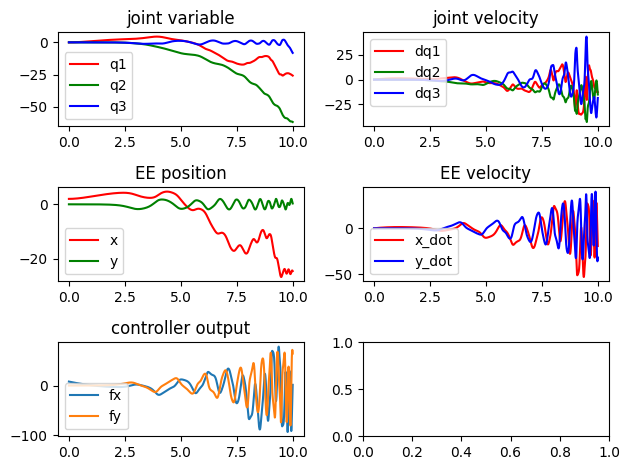

In [98]:
def simulate(simulation_time_step):
    
    builder = DiagramBuilder()
    
    plant = builder.AddSystem(PlanarPRR_continuous())
    end_effector_localizer = builder.AddSystem(PlanarPRR_forward_kin())
    #controller = builder.AddSystem(CartesianController(kx=1, ky=1, kx_dot=2, ky_dot=2))
    controller = builder.AddSystem(PidController(kp=[1, 1], ki=[-.5, 0.5], kd=[2., 2.]))
 
    logger_joint = LogVectorOutput(plant.get_output_port(), builder)
    logger_end_effector = LogVectorOutput(end_effector_localizer.get_output_port(0), builder)
    logger_controller = LogVectorOutput(controller.get_output_port(), builder)
   

    builder.Connect(plant.get_output_port(), end_effector_localizer.get_input_port(0))

    builder.Connect(end_effector_localizer.get_output_port(), controller.get_input_port_estimated_state())
    builder.Connect(controller.get_output_port_control(), plant.get_input_port())

    #builder.Connect(end_effector_localizer.get_output_port(), controller.get_input_port_actual_state())
    #builder.Connect(controller.get_output_port(), plant.get_input_port())
  

    diagram = builder.Build()
 
    root_context = diagram.CreateDefaultContext()
    plant_context = plant.GetMyContextFromRoot(root_context)
    controller_context = controller.GetMyContextFromRoot(root_context)

    plant_context.SetContinuousState([0, 0, 0, 0, 0, 0])
    controller.get_input_port_desired_state().FixValue(controller_context, np.array([10, 0.01, 0, 0]))


    simulatore = Simulator(diagram, root_context)
    simulatore.AdvanceTo(simulation_time_step)

    log_joint = logger_joint.FindLog(root_context)
    log_ee = logger_end_effector.FindLog(root_context)
    log_controller = logger_controller.FindLog(root_context)
    
    return log_joint, log_ee, log_controller
    
log_j, log_e, log_c = simulate(10)

plot_log(log_j, log_e, log_c)

